# Loading ClimSim

LEAP wide utility for loading in the Climsim dataset efficiently. The actual data lives on [huggingface](https://huggingface.co/datasets/LEAP/ClimSim_low-res_aqua-planet)

Tiers of Access/ [Dataset Information](https://leap-stc.github.io/ClimSim/dataset.html): 
1. High Resolution Data with Geography
2. Low resolution data with geography
3. Low Res aquaplanet
4. Quickstart toy data (subsampled version of low res data)

References : 

- [The Climsim Repo](https://github.com/leap-stc/ClimSim) is the most important resource and contains or links to basically all information.
- Tian assigned her stats class [the challenge of exploring](https://github.com/TZstatsADS/ADS_Teaching/tree/master/16-Fall2023/Projects_StarterCodes/Project3-ClimSim) loading up of the dataset.
- Can see how people did it from the [Kaggle Competition](https://www.kaggle.com/competitions/leap-atmospheric-physics-ai-climsim/code)

In [1]:
import xarray as xr
import numpy as np
import os
import sys
from tqdm import tqdm

import gcsfs
import fsspec
fs = gcsfs.GCSFileSystem()
import xbatcher
import torch
from torch import multiprocessing
from torch.utils.data import DataLoader

import time
import datetime
import json
from dataclasses import dataclass, asdict, field
from typing import List, Dict, Tuple, Optional
from typing_extensions import Annotated
import typer

import dask

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/srv/conda/envs/notebook'
sys.path.append(os.path.abspath(os.path.join('diffusionsim')))
import matplotlib.pyplot as plt

Use [E3SM-MMF Dataset Variable List](https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0) to check the physical meaning of each variable.

Check the original data coordinates first. Instead of using time, latitude, longitude as the coordinates, the raw data uses **sample**(time step) and **ncol**(column index).

In [2]:
from diffusionsim import mydatasets as data
import diffusionsim as diff

SyntaxError: invalid syntax. Perhaps you forgot a comma? (mydatasets.py, line 43)

## Loading from Huggingface

I changed the [original climsim data processing file](https://github.com/leap-stc/ClimSim/blob/main/climsim_utils/data_utils.py) to be workable with huggingface data (currently too slow because of lack of virtualization), local filesystem (which is what it's designed for), or from google cloud bucket (if we ingest again without solving copy_to_local) 

- Main motivation is retaining format for standardized evaluation
- Need to assess once we figure out the ideal pipeline

#### Check which variables are included & their dimensions/shapes 

Use [E3SM-MMF Dataset Variable List](https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0) to check the physical meaning of each variable.

Check the original data coordinates first. Instead of using time, latitude, longitude as the coordinates, the raw data uses **sample**(time step) and **ncol**(column index).

In [3]:
from diffusionsim import climsim_utils as cut

In [4]:
start, stop = cut.tocft(1, 2, 2), cut.tocft(1, 3, 1)

interval = datetime.timedelta(minutes=20)

In [5]:
urls = list(cut.generate_urls(start, stop, interval, "expanded_low-res", ["mlexpand", "mlo"]))

times = []
mli_urls = []
mlo_urls = []

for time, mli, mlo in urls:
    times.append(time)
    mli_urls.append(mli)
    mlo_urls.append(mlo)

print(f"{len(mlo_urls)} files comprising dataset")
mli_urls[0], mlo_urls[0]

1944 files comprising dataset


('https://huggingface.co/datasets/LEAP/ClimSim_low-res-expanded/resolve/main/train/0001-02/E3SM-MMF.mlexpand.0001-02-02-00000.nc',
 'https://huggingface.co/datasets/LEAP/ClimSim_low-res-expanded/resolve/main/train/0001-02/E3SM-MMF.mlo.0001-02-02-00000.nc')

In [7]:
data = cut.setup_data_utils(ds_type='expanded', data_source="hf", data_vars='v1')
data

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
module 'numpy' has no attribute 'cumproduct'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [8]:
data.set_filelist_using_intervals(
    "train", start, stop, interval
)
data.get_filelist('train') == mli_urls

True

In [6]:
sample_url = mlo_urls[5]
sample_url

'https://huggingface.co/datasets/LEAP/ClimSim_low-res-expanded/resolve/main/train/0001-02/E3SM-MMF.mlo.0001-02-02-06000.nc'

Trying to open in three ways: 

1. fsspec open, writing to local

In [7]:
def read_url_xarray_old(url):
    fs_local = fsspec.filesystem('local')
    with fsspec.open(url, mode='rb').open() as file: 
        with open("file.nc", 'wb') as f:
            f.write(file.read())
    # does not work
    #xr.open_dataset(file, engine="h5netcdf", chunks={}, use_cftime=True)   
    ds = xr.open_dataset("file.nc", use_cftime=True, chunks={})
    #fs_local.rm("file.nc")
    return(ds)

def read_url_xarray(url):
    fs_local = fsspec.filesystem('local')
    with fsspec.open(url, mode='rb').open() as file: 
        ds = xr.open_dataset(file, use_cftime=True, chunks={})
    #fs_local.rm("file.nc")
    return(ds)

In [8]:
%%time
ds1 = read_url_xarray_old(sample_url)
ds1

CPU times: user 1.39 s, sys: 248 ms, total: 1.64 s
Wall time: 2.51 s


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
module 'numpy' has no attribute 'cumproduct'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 1MB
Dimensions:         (ncol: 384, lev: 60)
Dimensions without coordinates: ncol, lev
Data variables: (12/16)
    ymd             int32 4B ...
    tod             int32 4B ...
    cam_out_FLWDS   (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    cam_out_NETSW   (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    cam_out_PRECC   (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    cam_out_PRECSC  (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    ...              ...
    state_q0001     (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_q0002     (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_q0003     (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_t         (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_u         (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_v         (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
Attributes:
    ne:        4
    fv_nphys:  2
    calendar:  NO_LEAP

In [9]:
%%time
ds1 = read_url_xarray(sample_url)
ds1

CPU times: user 49 ms, sys: 1.95 ms, total: 51 ms
Wall time: 332 ms


<xarray.Dataset> Size: 1MB
Dimensions:         (ncol: 384, lev: 60)
Dimensions without coordinates: ncol, lev
Data variables: (12/16)
    ymd             int32 4B ...
    tod             int32 4B ...
    cam_out_FLWDS   (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    cam_out_NETSW   (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    cam_out_PRECC   (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    cam_out_PRECSC  (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    ...              ...
    state_q0001     (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_q0002     (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_q0003     (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_t         (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_u         (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
    state_v         (lev, ncol) float64 184kB dask.array<chunksize=(60, 384), meta=np.ndarray>
Attributes:
    ne:        4
    fv_nphys:  2
    calendar:  NO_LEAP

2. virtualizarr virtual dataset

[vzarr](https://github.com/zarr-developers/VirtualiZarr/blob/main/examples/coiled/terraclimate.ipynb) example



In [10]:
import virtualizarr
from virtualizarr import open_virtual_dataset

In [11]:
## first explore local file

In [12]:
vds = open_virtual_dataset("file.nc")
vds

/srv/conda/envs/notebook/lib/python3.12/site-packages/virtualizarr/xarray.py:160: UserWarning: Specifying `indexes=None` will create in-memory pandas indexes for each 1D coordinate, but concatenation of ManifestArrays backed by pandas indexes is not yet supported (see issue #18).You almost certainly want to pass `indexes={}` to `open_virtual_dataset` instead.
  warnings.warn(


<xarray.Dataset> Size: 1MB
Dimensions:         (ncol: 384, lev: 60)
Dimensions without coordinates: ncol, lev
Data variables: (12/16)
    cam_out_NETSW   (ncol) float64 3kB ManifestArray<shape=(384,), dtype=floa...
    cam_out_PRECSC  (ncol) float64 3kB ManifestArray<shape=(384,), dtype=floa...
    cam_out_SOLSD   (ncol) float64 3kB ManifestArray<shape=(384,), dtype=floa...
    cam_out_FLWDS   (ncol) float64 3kB ManifestArray<shape=(384,), dtype=floa...
    state_v         (lev, ncol) float64 184kB ManifestArray<shape=(60, 384), ...
    cam_out_PRECC   (ncol) float64 3kB ManifestArray<shape=(384,), dtype=floa...
    ...              ...
    state_q0002     (lev, ncol) float64 184kB ManifestArray<shape=(60, 384), ...
    state_u         (lev, ncol) float64 184kB ManifestArray<shape=(60, 384), ...
    state_q0001     (lev, ncol) float64 184kB ManifestArray<shape=(60, 384), ...
    cam_out_SOLS    (ncol) float64 3kB ManifestArray<shape=(384,), dtype=floa...
    cam_out_SOLL    (ncol) float64 3kB ManifestArray<shape=(384,), dtype=floa...
    cam_out_SOLLD   (ncol) float64 3kB ManifestArray<shape=(384,), dtype=floa...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [17]:
def _fsspec_openfile_from_filepath(filepath: str, reader_options={},):
    """Converts input filepath to fsspec openfile object.

    Parameters
    ----------
    filepath : str
        Input filepath
    reader_options : dict, optional
        Dict containing kwargs to pass to file opener, by default {}

    Returns
    -------
    OpenFileType
        An open file-like object, specific to the protocol supplied in filepath.

    Raises
    ------
    NotImplementedError
        Raises a Not Implemented Error if filepath protocol is not supported.
    """

    import fsspec
    from upath import UPath

    universal_filepath = UPath(filepath)
    protocol = universal_filepath.protocol

    if reader_options is None:
        reader_options = {}

    storage_options = reader_options.get("storage_options", {})  # type: ignore

    fpath = fsspec.filesystem(protocol, **storage_options).open(filepath)

    return fpath

In [20]:
from upath import UPath

universal_filepath = UPath(sample_url)
protocol = universal_filepath.protocol
universal_filepath, protocol

In [18]:
_fsspec_openfile_from_filepath(sample_url)

<File-like object HTTPFileSystem, https://huggingface.co/datasets/LEAP/ClimSim_low-res-expanded/resolve/main/train/0001-02/E3SM-MMF.mlo.0001-02-02-06000.nc>

In [19]:
vds = open_virtual_dataset(sample_url) # fails

FileNotFoundError: https://huggingface.co/datasets/LEAP/ClimSim_low-res-expanded/resolve/main/train/0001-02/E3SM-MMF.mlo.0001-02-02-06000.nc

In [20]:
def open_virtual(url):
    with fsspec.open(url, mode='rb').open() as file:
        ds = open_virtual_dataset(file)
    return(ds)
#ds = open_virtual(sample_url)

In [29]:
sample_url

'https://huggingface.co/datasets/LEAP/ClimSim_low-res-expanded/resolve/main/train/0001-02/E3SM-MMF.mlo.0001-02-02-06000.nc'

In [22]:
import requests
resp = requests.get(sample_url)
with open('file2.nc', 'wb') as f:
    f.write(resp.content)
open_virtual_dataset("file2.nc")

#### 3. huggingface hub
Virtual Zarr generation mentioned on [climsim feedstock](https://github.com/leap-stc/climsim_feedstock/issues/9)

In [20]:
from huggingface_hub import HfFileSystem
import fsspec
fs = HfFileSystem()

In [21]:


old_files = fs.glob("datasets/LEAP/ClimSim_low-res/train/0001-02/*0001-02-01-00000.nc")

new_files = fs.glob(
    "datasets/LEAP/ClimSim_low-res-expanded/train/0001-02/*.nc"
)

In [22]:
len(new_files), new_files[3:5], new_files[-2:]

(4028,
 ['datasets/LEAP/ClimSim_low-res-expanded/train/0001-02/E3SM-MMF.mlexpand.0001-02-01-06000.nc',
  'datasets/LEAP/ClimSim_low-res-expanded/train/0001-02/E3SM-MMF.mlexpand.0001-02-01-07200.nc'],
 ['datasets/LEAP/ClimSim_low-res-expanded/train/0001-02/E3SM-MMF.mlo.0001-02-28-84000.nc',
  'datasets/LEAP/ClimSim_low-res-expanded/train/0001-02/E3SM-MMF.mlo.0001-02-28-85200.nc'])

Based on Julius [minimal example](https://github.com/leap-stc/climsim_feedstock/issues/9)

In [23]:
def open_hf_file(path):
    with fsspec.open('hf://'+path, mode='rb') as f:
        try:
            ds = xr.open_dataset(f).load()
            print(ds.dims)
        except:
            print("FAILED")

for files in [old_files, new_files[:2]]:
    for path in files:
        print(path)
        open_hf_file(path)

datasets/LEAP/ClimSim_low-res/train/0001-02/E3SM-MMF.mli.0001-02-01-00000.nc
FAILED
datasets/LEAP/ClimSim_low-res/train/0001-02/E3SM-MMF.mlo.0001-02-01-00000.nc
FAILED
datasets/LEAP/ClimSim_low-res-expanded/train/0001-02/E3SM-MMF.mlexpand.0001-02-01-02400.nc
FrozenMappingWarningOnValuesAccess({'ncol': 384, 'lev': 60})
datasets/LEAP/ClimSim_low-res-expanded/train/0001-02/E3SM-MMF.mlexpand.0001-02-01-03600.nc
FrozenMappingWarningOnValuesAccess({'ncol': 384, 'lev': 60})


In [52]:
pth = "hf://" + new_files[0]
pth

'hf://datasets/LEAP/ClimSim_low-res-expanded/train/0001-02/E3SM-MMF.mlexpand.0001-02-01-02400.nc'

In [58]:
with fsspec.open(pth, mode='rb') as f:
    ds = xr.open_dataset(f, engine="h5netcdf")

In [59]:
ds

<xarray.Dataset> Size: 6MB
Dimensions:                (ncol: 384, lev: 60)
Dimensions without coordinates: ncol, lev
Data variables: (12/61)
    ymd                    int32 4B ...
    tod                    int32 4B ...
    cam_in_ALDIF           (ncol) float64 3kB ...
    cam_in_ALDIR           (ncol) float64 3kB ...
    cam_in_ASDIF           (ncol) float64 3kB ...
    cam_in_ASDIR           (ncol) float64 3kB ...
    ...                     ...
    tm_pbuf_COSZRS         (ncol) float64 3kB ...
    lat                    (ncol) float64 3kB ...
    lon                    (ncol) float64 3kB ...
    clat                   (ncol) float64 3kB ...
    slat                   (ncol) float64 3kB ...
    icol                   (ncol) float64 3kB ...
Attributes:
    ne:        4
    fv_nphys:  2
    calendar:  NO_LEAP

In [23]:
open_hf_file(old_files[0])

datasets/LEAP/ClimSim_low-res/train/0001-02/E3SM-MMF.mli.0001-02-01-00000.nc
FAILED


In [11]:
#dsi = ds_input.stack({'batch':{'ncol'}})
#dsi.to_stacked_array('mlvar', sample_dims=['batch'], name='mli')
#ds_input, ds_target = data.get_input(files[0]), data.get_target(files[1])
#ds_target = ds_target.stack({'batch':{'ncol'}})
#ds_target = ds_target.to_stacked_array('mlvar', sample_dims=['batch'], name='mlo')


In [ ]:

dataset = data.load_ncdata_with_generator("train")
dataset

In [ ]:
from climsim_utils import *
start = tocft(1, 2, 1)
stop = tocft(1, 2, 2)
interval = dt.timedelta(minutes=120)
input_ds, output_ds = load_climsim(start, stop, interval)

#import shutil
#shutil.rmtree("gs://leap-scratch/sammyagrawal/aquaplanet_out_1.zarr", 
# ignore_errors=True)
#path = "gs://leap-scratch/sammyagrawal"
#input_ds.to_zarr("gs://leap-scratch/sammyagrawal/aquaplanet_in_3.zarr")
#output_ds.to_zarr("gs://leap-scratch/sammyagrawal/aquaplanet_out_3.zarr")

## From Cloud Bucket

Soon to be deprecated, (ClimSim is currently being re-ingested) but for now the easiest way to load the data is from the low-res version in Sungduk's directory. Julius is working on Climsim ingestion right now, so perhaps new and improved versions will exist in leap-persistent bucket

Most utilities for this have been placed in climsim_training_utils.py

In [5]:
from typing import List, Dict, Tuple
from dataclasses import dataclass, asdict, field

In [7]:
@dataclass
class TrainLoaderParams:
    batch_size: int = 32
    shuffle: bool = False
    num_workers: int = 8
    prefetch_factor: int = 6
    persistent_workers: bool = True
    multiprocessing_context: str = "forkserver"

@dataclass
class DataConfig:
    dataset_type: str = "XBatchDataset"
    climsim_type: str = "low-res"
    source = "gcsfs"
    train_test_split: List[int] = field(default_factory=lambda: [0.75, 0.25])
    dataloader_params: TrainLoaderParams = field(default_factory=lambda: TrainLoaderParams())
    xarr_subsamples: Tuple[int, int, int] = (36,210240, 144)
    data_vars: str = "v1"
    use_tendencies: bool = False
    norm_info: str = "nc"
    chunksize: Dict = field(default_factory=lambda:{})
    def __post_init__(self):
        if isinstance(self.dataloader_params, dict):
            self.dataloader_params = TrainLoaderParams(**self.dataloader_params)


In [8]:
dconfig = DataConfig()

In [9]:
dconfig.chunksize

{}

In [1]:
def load_raw_dataset(ds_type='', chunks=False, chunksizes={}):
    # change once re-ingested/ virtualized pipeline works
    # eventually want ds_type to specify aquaplanet / res    
    if(chunks):
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
        ds_input = xr.open_dataset(mapper, engine='zarr', chunks=chunksizes)
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
        ds_output = xr.open_dataset(mapper, engine='zarr', chunks=chunksizes)
    else:
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
        ds_input = xr.open_dataset(mapper, engine='zarr')
        mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
        ds_output = xr.open_dataset(mapper, engine='zarr')
    return(ds_input, ds_output)

In [ ]:
input_vars, output_vars = data.load_vars('v1', tendencies=False)
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds_out = xr.open_dataset(mapper, engine='zarr', chunks={})
ds_out = ds_out[output_vars].rename({'sample':'time'})
ds_out = data.add_space(ds_out)
dataset = data.XBatchDataset(ds_out, dconfig.dataloader_params.batch_size, 
                             mconfig, normalize=False, log=True)

In [3]:
ds_in, ds_out = data.load_raw_dataset(chunks = True)

In [4]:
input_vars, output_vars = data.load_vars('v1', tendencies=False)

In [5]:
ds_in, ds_out = data.add_time(ds_in, ds_out)

In [14]:
set(['time', 'ncol']) <= set(ds_in.dims)

True

In [7]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    
    dsi = ds_in[input_vars].to_stacked_array('mli', sample_dims=['sample', 'ncol'])
    dso = ds_out[output_vars].to_stacked_array('mlo', sample_dims=['sample', 'ncol'])

In [8]:
ds_input, ds_output = data.add_space(dsi, dso)

In [10]:
dsi.mean(dim='sample')

<xarray.DataArray 'state_t' (ncol: 384, mli: 124)> Size: 381kB
dask.array<mean_agg-aggregate, shape=(384, 124), dtype=float64, chunksize=(384, 60), chunktype=numpy.ndarray>
Coordinates:
  * mli       (mli) object 992B MultiIndex
  * variable  (mli) <U11 5kB 'state_t' 'state_t' ... 'pbuf_LHFLX' 'pbuf_SHFLX'
  * lev       (mli) object 992B 0 1 2 3 4 5 6 7 ... 56 57 58 59 nan nan nan nan
Dimensions without coordinates: ncol

In [9]:
dsi.stack({'state' : ['sample', 'ncol']})

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/util/deprecation_helpers.py:140: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return func(*args, **kwargs)


<xarray.DataArray 'state_t' (mli: 124, state: 80732160)> Size: 80GB
dask.array<reshape, shape=(124, 80732160), dtype=float64, chunksize=(60, 580608), chunktype=numpy.ndarray>
Coordinates:
  * mli       (mli) object 992B MultiIndex
  * variable  (mli) <U11 5kB 'state_t' 'state_t' ... 'pbuf_LHFLX' 'pbuf_SHFLX'
  * lev       (mli) object 992B 0 1 2 3 4 5 6 7 ... 56 57 58 59 nan nan nan nan
  * state     (state) object 646MB MultiIndex
  * sample    (state) int64 646MB 0 0 0 0 0 ... 210239 210239 210239 210239
  * ncol      (state) int64 646MB 0 1 2 3 4 5 6 ... 377 378 379 380 381 382 383

### Making Climsim "Images"

In [7]:
from climsim_utils import load_grid_info
ds_grid = load_grid_info('low-res')

In [6]:
pmap = ds_output.isel(sample=10).state_t
pmap.plot(yincrease=False)

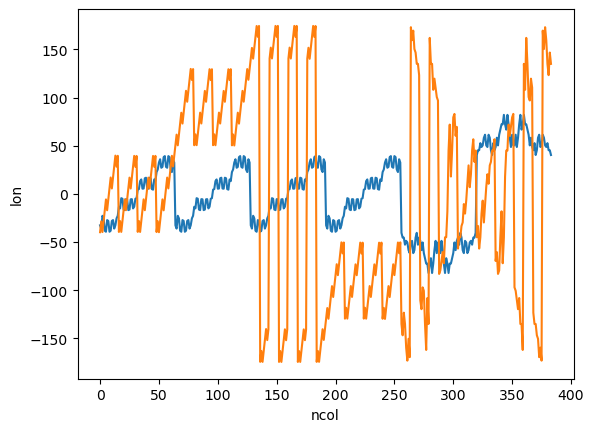

In [8]:
lat, lon = np.round(pmap.lat), np.round(pmap.lon)
pmap.lat.plot()
pmap.lon.plot()

In [9]:
def image_regridding(ds):
    lat, lon = np.round(ds.lat.data), np.round(ds.lon.data)
    array = np.column_stack([lon, lat])
    # first sort by longitude, then by latitude (top is area of high longitude)
    sorted_indices = np.lexsort((array[:, 0], -1*array[:, 1]))
    arr = array[sorted_indices]
    indices = np.array([], dtype=int)
    for i in range(16):
        start = i*24
        indices = np.concatenate([indices, start + np.argsort(arr[start:start+24, 0])])

    return(sorted_indices[indices])

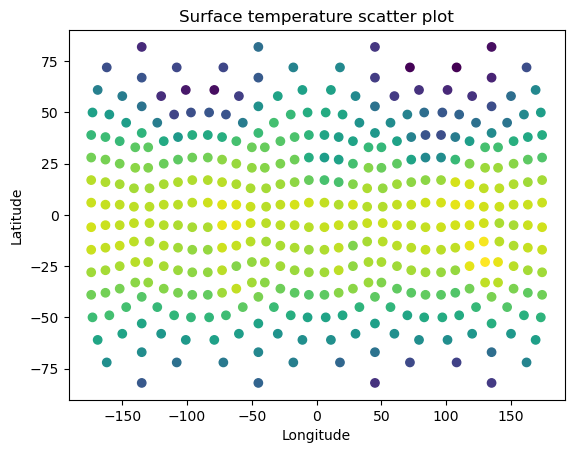

In [18]:
plt.scatter(lon, lat, c=pmap.sel(lev=59).values)
plt.title("Surface temperature scatter plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [38]:
ds = ds_input
lat, lon = np.round(ds.lat.data), np.round(ds.lon.data)
array = np.column_stack([lon, lat])
# first sort by longitude, then by latitude (top is area of high longitude)
sorted_indices = np.lexsort((array[:, 0], -1*array[:, 1]))
arr = array[sorted_indices]
indices = np.array([], dtype=int)
for i in range(16):
    start = i*24
    indices = np.concatenate([indices, start + np.argsort(arr[start:start+24, 0])])

t = sorted_indices[indices]

In [40]:
test = image_regridding(ds_input)

In [41]:
xv, yv = np.meshgrid(np.unique(lon), np.unique(lat))

In [46]:
temps = pmap.sel(lev=59).values
coord = list(zip(np.round(pmap.lat.values), np.round(pmap.lon.values)))

In [47]:
grid = array[t].reshape(16, 24, 2)

In [48]:
map_vals = np.zeros_like(xv)
map_vals

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
for index, (lat, lon) in enumerate(coord):
    i, j = np.where(np.unique(lat)==lat)[0][0], np.where(np.unique(lon) == lon)[0][0]
    map_vals[i, j] = temps[index]

In [53]:
yv

array([[-82., -82., -82., ..., -82., -82., -82.],
       [-72., -72., -72., ..., -72., -72., -72.],
       [-67., -67., -67., ..., -67., -67., -67.],
       ...,
       [ 67.,  67.,  67., ...,  67.,  67.,  67.],
       [ 72.,  72.,  72., ...,  72.,  72.,  72.],
       [ 82.,  82.,  82., ...,  82.,  82.,  82.]])

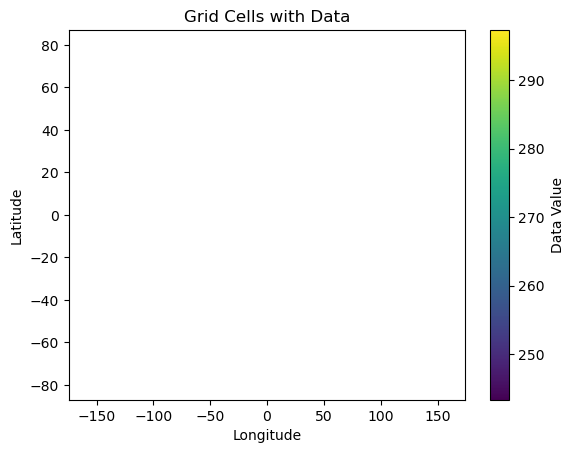

In [51]:
masked_data = np.ma.masked_where(map_vals == 0, map_vals)

plt.pcolormesh(xv, yv, masked_data, cmap='viridis')
plt.colorbar(label='Data Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Grid Cells with Data')
plt.show()

In [54]:
temp_map = pmap[:, t].sel(lev=59).values.reshape(16, 24)

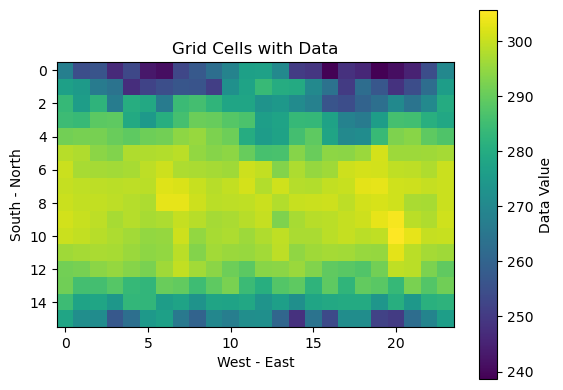

In [55]:
plt.imshow(temp_map, cmap='viridis')
plt.colorbar(label='Data Value')
plt.xlabel('West - East')
plt.ylabel('South - North')
plt.title('Grid Cells with Data')
plt.show()

(array([  6.,  12.,  16.,  13.,  27.,  38.,  39.,  47., 119.,  67.]),
 array([238.59647127, 245.308874  , 252.02127674, 258.73367947,
        265.44608221, 272.15848494, 278.87088768, 285.58329041,
        292.29569315, 299.00809589, 305.72049862]),
 <BarContainer object of 10 artists>)

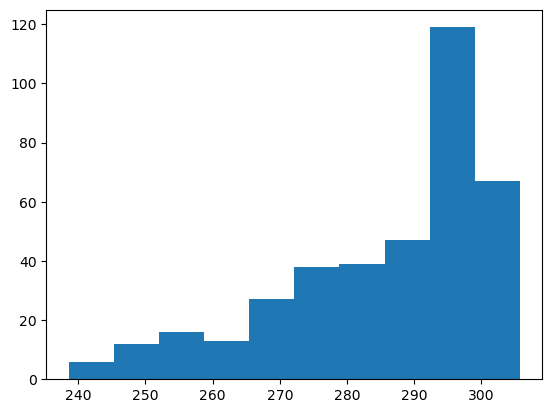

In [21]:
plt.hist(pmap.sel(lev=59))

### normalizing and saving arrays

In [49]:
input_mean, input_max, input_min, output_scale = data.get_norm_info('nc')


AttributeError: module 'diffusionsim.mydatasets' has no attribute 'get_norm_info'

In [ ]:
ds_input = (ds_input - input_mean)/(input_max - input_min)
ds_target = ds_output*output_scale

In [50]:
from dask.diagnostics import ProgressBar
def ds_to_npy(ds, load=False):
    ds = ds.stack({'sample' : ['time', 'ncol']}) # stacks the time and ncol into one MultiIndex
    ds = ds.to_stacked_array('mlvar', sample_dims=['sample']) # turns the data array of multiple vars into one stacked var
    if(load):
        print(f"{ds.nbytes / 1e9} gigabytes") # GB
        # visualize with progress bar
        with ProgressBar():
            # use .load() or .compute() to do the math and get the daily mean data
            ds.load()
    return(ds)


def save_arrays(X, Y, bucket='scratch', fprefix='climsim'):
    if(bucket== 'scratch'):
        bucket = "leap-scratch"
    elif(bucket == 'persist'):
        bucket = "leap-persistent"
    with fsspec.open(f"gs://{bucket}/sammyagrawal/input_{fprefix}.npy", 'wb') as f:
        np.save(f, X)
    with fsspec.open(f"gs://{bucket}/sammyagrawal/output_{fprefix}.npy", 'wb') as f:
        np.save(f, Y)

In [15]:
from dask.diagnostics import ProgressBar

In [ ]:

input_mean = dsi.mean(dim='time')
input_std = dsi.std(dim='time')
with ProgressBar():
    input_mean.load()
    input_std.load()

input_mean.reset_index('mli').to_netcdf("image_xmean.nc")
input_std.reset_index('mli').to_netcdf("image_xstd.nc")

In [24]:
xm, xs, ym, ys = data.get_norm_info("image")

In [16]:
ds_in, ds_out = data.load_raw_dataset(chunks = True)
input_vars, output_vars = data.load_vars('v1', tendencies=False)

In [20]:
output_mean = ds_in[input_vars].rename({'sample':'time'}).mean(dim='time')
output_std = ds_out[output_vars].rename({'sample':'time'}).std(dim='time')
with ProgressBar():
    output_mean.load()
    output_std.load()

[########################################] | 100% Completed | 173.72 s
[########################################] | 100% Completed | 187.71 s


In [21]:
input_mean = output_mean

In [22]:
output_mean = ds_out[output_vars].rename({'sample':'time'}).mean(dim='time')
with ProgressBar():
    output_mean.load()

[########################################] | 100% Completed | 176.01 s


In [26]:
output_mean.to_netcdf("output_mean.nc")

In [27]:
output_std.to_netcdf("output_std.nc")

#### Spatial Filtering

In [ ]:
def load_latlon():
    mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
    ds_grid = xr.open_dataset(mapper, engine='zarr')
    lat = ds_grid.lat.values.round(2) 
    lon = ds_grid.lon.values.round(2)  
    return(lat, lon)

lat, lon = load_latlon()
print(list(zip(lat, lon))[:5])

In [ ]:
def select_region(condition):
    # assumes condition is a lambda function taking in a lat and lon
    # returns the indices for which this is true
    lat, lon = load_latlon()
    latlon = pd.DataFrame({"lat" : lat, "lon": lon})
    return(list(latlon[latlon.apply(condition, axis=1)].index))

def split_ds_by_area(ds, condition):
    match = select_region(condition)
    unmatch = select_region(lambda row : not condition(row))
    return(ds.isel(ncol=match), ds.isel(ncol=unmatch))

f = lambda row : row.lat > 50
train, test = split_ds_by_area(ds, f)

# Streaming Zarr to Batches: Optimization

Xbatcher [Demo and tutorial](https://xbatcher.readthedocs.io/en/latest/tutorials-and-presentations.html)

Factors of variation: 
- dask batch chunking and how computation graph was setup
- Once dask graph is setup, it is run using a [scheduler](https://docs.dask.org/en/stable/scheduler-overview.html) in which various levels of parallelism can be implemented.
- The number of workers assigned to both dask and xbatcher. Optimality depends on hardware and time for each task
- Sampling and torch dataset/dataloader configs


Resources: 
[Dask chunk sizing guidelines](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes)

### Preparing Data

In [3]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/sammyagrawal/proxy/8787/status,
Dashboard: /user/sammyagrawal/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 29.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34181,Workers: 4
Dashboard: /user/sammyagrawal/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 29.38 GiB
Comm: tcp://127.0.0.1:45515,Total threads: 2
Dashboard: /user/sammyagrawal/proxy/35177/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:46695,


In [7]:
input_vars, output_vars = data.load_vars('v1', tendencies=False)

In [8]:
def imshow(vmap, title=''):
    plt.imshow(vmap)
    plt.title(title)
    plt.colorbar()
    plt.show()

In [9]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds_in = xr.open_dataset(mapper, engine='zarr', chunks={})
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds_out = xr.open_dataset(mapper, engine='zarr', chunks={})

ds_in, ds_out = ds_in[input_vars].rename({'sample':'time'}), ds_out[output_vars].rename({'sample':'time'})

In [10]:
ds_out['cam_out_PRECSC']

<xarray.Dataset> Size: 83GB
Dimensions:         (time: 210240, lev: 60, ncol: 384)
Dimensions without coordinates: time, lev, ncol
Data variables:
    state_t         (time, lev, ncol) float64 39GB dask.array<chunksize=(1512, 60, 384), meta=np.ndarray>
    state_q0001     (time, lev, ncol) float64 39GB dask.array<chunksize=(1512, 60, 384), meta=np.ndarray>
    cam_out_NETSW   (time, ncol) float64 646MB dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_FLWDS   (time, ncol) float64 646MB dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_PRECSC  (time, ncol) float64 646MB dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_PRECC   (time, ncol) float64 646MB dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_SOLS    (time, ncol) float64 646MB dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_SOLL    (time, ncol) float64 646MB dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_SOLSD   (time, ncol) float64 646MB dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_SOLLD   (time, ncol) float64 646MB dask.array<chunksize=(1512, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [5]:
ds_in

NameError: name 'ds_in' is not defined

In [6]:
ds_out = data.add_space(ds_out)
permute_indices = diff.mydatasets.image_regridding(ds_out)

In [50]:
temp = ds_out.state_t.data[0]
temp

dask.array<getitem, shape=(60, 384), dtype=float64, chunksize=(60, 384), chunktype=numpy.ndarray>

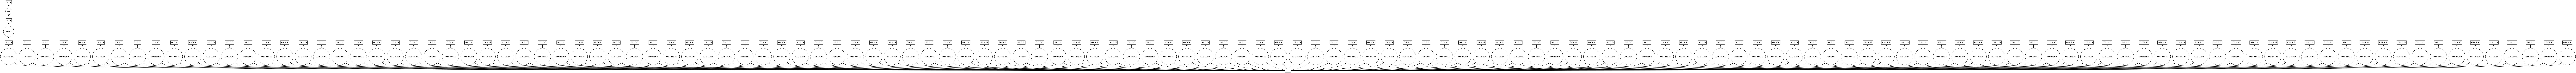

In [51]:
y = 2*temp
y.visualize()

In [52]:
batch_patch = dict(time=32, lev=60, ncol=384)
bgen = xbatcher.BatchGenerator(
        ds_out.isel(ncol=permute_indices),
        input_dims=batch_patch,
        preload_batch=False,
    )

In [53]:
%%time
batch = bgen[40].load()

CPU times: user 444 ms, sys: 143 ms, total: 587 ms
Wall time: 5.25 s


In [54]:
batch

<xarray.Dataset> Size: 13MB
Dimensions:         (time: 32, lev: 60, ncol: 384)
Dimensions without coordinates: time, lev, ncol
Data variables:
    state_t         (time, lev, ncol) float64 6MB 206.4 216.7 ... 253.1 275.8
    state_q0001     (time, lev, ncol) float64 6MB 1.434e-06 ... 0.004576
    cam_out_NETSW   (time, ncol) float64 98kB 2.567 0.0 47.34 ... 55.74 40.38
    cam_out_FLWDS   (time, ncol) float64 98kB 256.3 112.4 146.6 ... 168.0 322.7
    cam_out_PRECSC  (time, ncol) float64 98kB 5.867e-08 1.872e-09 ... 2.006e-08
    cam_out_PRECC   (time, ncol) float64 98kB 5.867e-08 1.872e-09 ... 3.996e-08
    cam_out_SOLS    (time, ncol) float64 98kB 1.843e-55 0.0 ... 85.98 8.844e-08
    cam_out_SOLL    (time, ncol) float64 98kB 4.491e-55 0.0 ... 130.9 7.651e-07
    cam_out_SOLSD   (time, ncol) float64 98kB 7.103 0.0 36.96 ... 74.03 25.69
    cam_out_SOLLD   (time, ncol) float64 98kB 4.502 0.0 21.17 ... 36.27 17.26
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [11]:
#from diff.trainers import DiffusionTrainer
#trainer = DiffusionTrainer(

#### Pre-processing games

In [12]:
input_mean, input_std, output_mean, output_std = data.get_norm_info("image")
output_std['cam_out_PRECSC'].data = output_std.cam_out_PRECSC.mean().item() * np.ones_like(output_std.cam_out_PRECSC.data) 


In [20]:
batch_norm = (batch - output_mean.mean(dim='ncol')) / output_std.mean(dim='ncol')
stacked = batch_norm.to_stacked_array(new_dim="mlo", sample_dims=("time", "ncol"))
stacked = stacked.transpose("time", "mlo", "ncol").isel(ncol=permute_indices)

In [21]:
height, width = (16, 24)
item = torch.tensor(stacked.data.reshape(-1, 128, height, width), dtype=torch.float32)

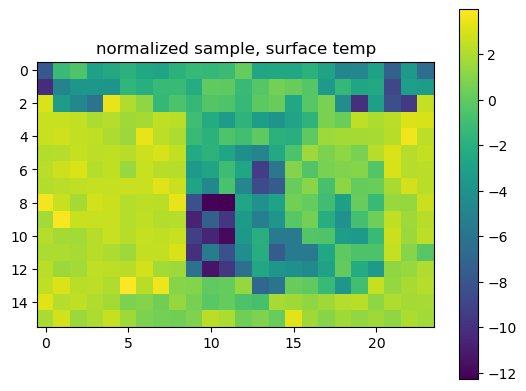

In [22]:
imshow(item[0,59,:,:], "normalized sample, surface temp")

In [128]:
dataset = setup(32)
training_generator = torch.utils.data.DataLoader(dataset, **dict(
    batch_size=1, shuffle=False, collate_fn=lambda batches : batches[0],
))

In [125]:
first = next(iter(training_generator))

{"event": "get-batch start", "time": 1724379034.4985912, "pid": 4592, "batch_idx": 0}
{"event": "get-batch end", "time": 1724379036.5391464, "pid": 4592, "batch_idx": 0, "duration": 2.0405516624450684}


In [126]:
first.shape

torch.Size([32, 128, 16, 24])

In [43]:
%%time
mbatch = ds_out.isel(time=slice(0,32)).load()

CPU times: user 1.2 s, sys: 941 ms, total: 2.14 s
Wall time: 1.87 s


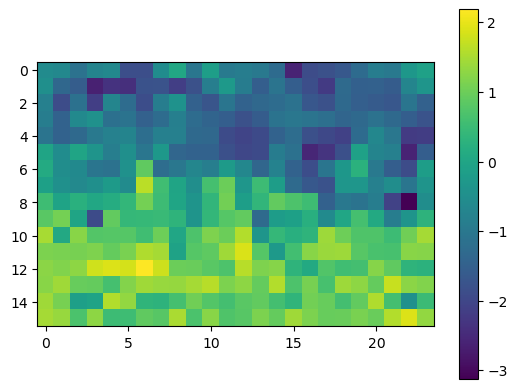

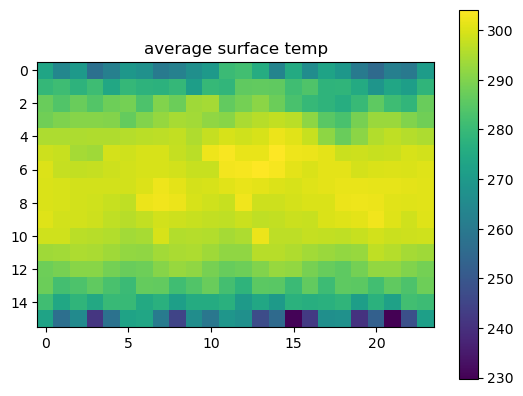

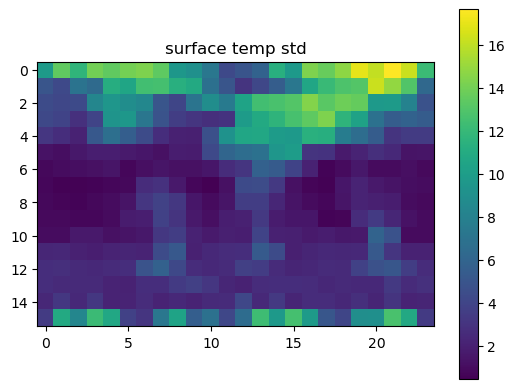

In [77]:
tmap = mbatch.state_t.isel(time=0, lev=59, ncol=permute_indices).data.reshape(16, 24)
t_avg = output_mean.state_t.sel(lev=59, ncol=permute_indices).data.reshape(16, 24)
t_std = output_std.state_t.sel(lev=59, ncol=permute_indices).data.reshape(16, 24)
imshow((tmap-t_avg) / t_std)
imshow(t_avg, "average surface temp")
imshow(t_std, "surface temp std")

(array([15., 26., 51., 82., 83., 78., 34.,  8.,  2.,  5.]),
 array([21.90898579, 24.63856908, 27.36815236, 30.09773565, 32.82731893,
        35.55690221, 38.2864855 , 41.01606878, 43.74565206, 46.47523535,
        49.20481863]),
 <BarContainer object of 10 artists>)

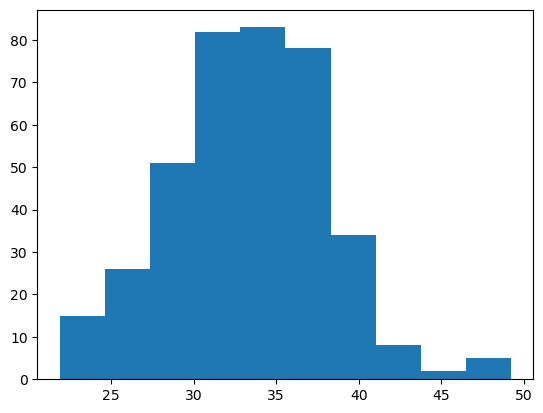

In [48]:
plt.hist(output_mean.cam_out_SOLSD.data)

In [24]:
%%time
item = ds_out.sel(time=0)
item.load()

CPU times: user 1.19 s, sys: 1.04 s, total: 2.23 s
Wall time: 2.15 s


<xarray.Dataset> Size: 402kB
Dimensions:         (lev: 60, ncol: 384)
Coordinates:
  * ncol            (ncol) int64 3kB 0 1 2 3 4 5 6 ... 378 379 380 381 382 383
    lat             (ncol) float64 3kB -32.59 -35.99 -22.69 ... 45.34 40.39
    lon             (ncol) float64 3kB -39.73 -28.47 -39.56 ... 146.7 135.0
Dimensions without coordinates: lev
Data variables:
    state_t         (lev, ncol) float64 184kB 213.8 213.2 217.1 ... 264.4 270.1
    state_q0001     (lev, ncol) float64 184kB 1.485e-06 1.487e-06 ... 0.002065
    cam_out_NETSW   (ncol) float64 3kB 0.0 0.0 0.0 0.0 ... 139.2 291.3 233.0
    cam_out_FLWDS   (ncol) float64 3kB 349.6 335.2 401.7 ... 174.2 211.3 262.6
    cam_out_PRECSC  (ncol) float64 3kB 0.0 0.0 0.0 ... 4.867e-09 5.12e-09
    cam_out_PRECC   (ncol) float64 3kB 2.948e-12 3.138e-09 ... 5.792e-09
    cam_out_SOLS    (ncol) float64 3kB 0.0 0.0 0.0 0.0 ... 67.27 56.13 62.05
    cam_out_SOLL    (ncol) float64 3kB 0.0 0.0 0.0 0.0 ... 117.6 155.4 72.52
    cam_out_SOLSD   (ncol) float64 3kB 0.0 0.0 0.0 0.0 ... 33.03 88.19 74.27
    cam_out_SOLLD   (ncol) float64 3kB 0.0 0.0 0.0 0.0 ... 4.188 33.46 49.64
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [25]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dso_rechunked = ds_out[output_vars].to_stacked_array('mlo', sample_dims=['time', 'ncol'])
    dso_rechunked  = dso_rechunked.chunk({'time':1440, 'mlo': 128})
dso_rechunked

<xarray.DataArray 'state_t' (time: 210240, ncol: 384, mlo: 128)> Size: 83GB
dask.array<rechunk-merge, shape=(210240, 384, 128), dtype=float64, chunksize=(1440, 384, 128), chunktype=numpy.ndarray>
Coordinates:
  * ncol      (ncol) int64 3kB 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
    lat       (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    lon       (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
Dimensions without coordinates: time

In [26]:
dso_rechunked.chunksizes

Frozen({'time': (1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440), 'ncol': (384,), 'mlo': (128,)})

In [28]:
dsi, dso = data.add_space(ds_in[input_vars]), data.add_space(ds_out[output_vars])

In [29]:
## Applying image transforms
permute_indices = data.image_regridding(dso)
dsi = dsi.isel(ncol=permute_indices)
dso = dso.isel(ncol=permute_indices)

In [30]:
ystd = dso.std(dim='time')

In [31]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsi = dsi.to_stacked_array('mli', sample_dims=['time', 'ncol'])
    dso = dso.to_stacked_array('mlo', sample_dims=['time', 'ncol'])
    dsi, dso = dsi.transpose('time', 'mli', 'ncol'), dso.transpose('time', 'mlo', 'ncol')

In [33]:
print(f"input ds:{dsi.nbytes / 1e9} GB, output ds:{dso.nbytes / 1e9} gb")
dso

input ds:80.08630272 GB, output ds:82.66973184 gb


<xarray.DataArray 'state_t' (time: 210240, mlo: 128, ncol: 384)> Size: 83GB
dask.array<transpose, shape=(210240, 128, 384), dtype=float64, chunksize=(1512, 60, 384), chunktype=numpy.ndarray>
Coordinates:
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
Dimensions without coordinates: time

### Setting up Dask Gateway

1. First define cluster configurations
2. Access Client

In [12]:
@dataclass
class DataConfig:
    chunksize: Dict = field(default_factory=lambda : {})
    shuffle: bool = False
    batch_size: int = 1
    num_workers: int = 0
    prefetch_factor: int = None
    persistent_workers: bool = False
    pin_memory: bool = False
    train_step_time: Annotated[Optional[float], typer.Option()] = 0.1
    dask_threads: Annotated[Optional[int], typer.Option()] = None
    dask_scheduler: str = 'single-threaded'
    bg_input_dims: Dict = field(default_factory=lambda : dict(time=32, ncol=384))
    multiprocessing_context:str = None


params = DataConfig()

if params.num_workers:
    params.multiprocessing_context = multiprocessing.get_start_method()
    params.multiprocessing_context = "forkserver" 

dask.config.set(scheduler=params.dask_scheduler)

In [13]:
from dask_gateway import GatewayCluster, Gateway

gateway = Gateway()
options = gateway.cluster_options()

In [14]:
options

In [36]:
gateway.list_clusters()

[]

In [35]:
cluster = gateway.connect('prod.c2afd6b0586d4106aa79d01c866fd7cb')
cluster.close(shutdown=True)

In [30]:
cluster2 = gateway.connect('prod.f82a9e80600c4b528af812da25877212')

In [33]:
cluster2.close(shutdown=True)

In [15]:
manual = False
if(not len(gateway.list_clusters())):
    if(manual):
        cluster = gateway.new_cluster(options)
        cluster.scale(...)
        client = cluster.get_client()
    
    else: 
        cluster = GatewayCluster()
        cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.

In [25]:
gateway.list_clusters()

[ClusterReport<name=prod.c2afd6b0586d4106aa79d01c866fd7cb, status=RUNNING>,
 ClusterReport<name=prod.f82a9e80600c4b528af812da25877212, status=RUNNING>]

In [17]:
cluster = gateway.connect('prod.c2afd6b0586d4106aa79d01c866fd7cb')

In [18]:
client = cluster.get_client()

In [19]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.c2afd6b0586d4106aa79d01c866fd7cb/status,


### Speed Tests

Thread on dask batching [on github](https://github.com/leap-stc/data-and-compute-team/issues/13)

In [34]:
%%time
item = dso[0]
item.compute()

CPU times: user 1.83 s, sys: 869 ms, total: 2.69 s
Wall time: 2.19 s


<xarray.DataArray 'state_t' (mlo: 128, ncol: 384)> Size: 393kB
array([[212.93944876, 215.73457537, 214.45043524, ..., 227.67793078,
        221.88893832, 215.8721664 ],
       [225.27407895, 230.26559784, 226.83511904, ..., 233.17314   ,
        231.65997021, 225.92427627],
       [227.34468702, 231.71402699, 229.34320535, ..., 249.24925532,
        246.16620525, 241.15877414],
       ...,
       [  6.83355332,   0.        ,   0.        , ..., 165.05672721,
         23.99312923, 108.65008949],
       [ 47.75033812,   0.        ,   0.        , ...,  97.29014512,
        286.76433801, 129.05538561],
       [ 38.58727197,   0.        ,   0.        , ...,  55.84197809,
        173.18816257, 119.0154835 ]])
Coordinates:
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan

In [46]:
item

<xarray.DataArray 'state_t' (mlo: 128, ncol: 384)> Size: 393kB
dask.array<getitem, shape=(128, 384), dtype=float64, chunksize=(60, 384), chunktype=numpy.ndarray>
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan

Does chunk size affect loading time? 

In [4]:
%%time
item = dso_rechunked[5000]
item.compute()

NameError: name 'dso_rechunked' is not defined

#### xbatcher

In [140]:
dso

<xarray.DataArray 'state_t' (time: 210240, mlo: 128, ncol: 384)> Size: 83GB
dask.array<transpose, shape=(210240, 128, 384), dtype=float64, chunksize=(1512, 60, 384), chunktype=numpy.ndarray>
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
Dimensions without coordinates: time

In [141]:
params

DataConfig(chunksize={}, shuffle=False, batch_size=32, num_workers=0, prefetch_factor=None, persistent_workers=False, pin_memory=False, train_step_time=0.1, dask_threads=None, dask_scheduler='single-threaded', bg_input_dims={'time': 32, 'ncol': 384}, multiprocessing_context=None)

In [ ]:
#dso_unstack = dso.unstack('mlo')
#dso_unstack

bgen = xbatcher.BatchGenerator(
        dso, batch_dims=dict(time=params.batch_size),
        #input_overlap=overlap,
        #preload_batch=False,
    )
next(iter(bgen))

In [148]:
bgen = xbatcher.BatchGenerator(dso, input_dims=dict(time=params.batch_size, mlo=128, ncol=384))

In [150]:
next(iter(bgen))

<xarray.DataArray 'state_t' (time: 32, mlo: 128, ncol: 384)> Size: 13MB
array([[[2.12939449e+02, 2.15734575e+02, 2.14450435e+02, ...,
         2.27677931e+02, 2.21888938e+02, 2.15872166e+02],
        [2.25274079e+02, 2.30265598e+02, 2.26835119e+02, ...,
         2.33173140e+02, 2.31659970e+02, 2.25924276e+02],
        [2.27344687e+02, 2.31714027e+02, 2.29343205e+02, ...,
         2.49249255e+02, 2.46166205e+02, 2.41158774e+02],
        ...,
        [6.83355332e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.65056727e+02, 2.39931292e+01, 1.08650089e+02],
        [4.77503381e+01, 0.00000000e+00, 0.00000000e+00, ...,
         9.72901451e+01, 2.86764338e+02, 1.29055386e+02],
        [3.85872720e+01, 0.00000000e+00, 0.00000000e+00, ...,
         5.58419781e+01, 1.73188163e+02, 1.19015483e+02]],

       [[2.12997790e+02, 2.15688434e+02, 2.14408116e+02, ...,
         2.27623903e+02, 2.21859297e+02, 2.15843766e+02],
        [2.25418830e+02, 2.30175389e+02, 2.26460544e+02, ...,
         2.33175675e+02, 2.31741030e+02, 2.25857661e+02],
        [2.27530564e+02, 2.31685453e+02, 2.29138022e+02, ...,
         2.49235636e+02, 2.46177212e+02, 2.41082782e+02],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.30566582e+01, 1.76668046e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.59037850e+01, 1.61797981e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.25231659e+01, 1.03056120e+01, 0.00000000e+00]],

       [[2.13364933e+02, 2.16065807e+02, 2.14853080e+02, ...,
         2.26906327e+02, 2.22441726e+02, 2.16759947e+02],
        [2.28376933e+02, 2.30014248e+02, 2.27207024e+02, ...,
         2.34358693e+02, 2.32912307e+02, 2.28690071e+02],
        [2.28902454e+02, 2.32242429e+02, 2.30886098e+02, ...,
         2.49661022e+02, 2.46595084e+02, 2.40584942e+02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.54454325e+01, 1.43528277e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.43972480e+01, 1.13511725e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.26185983e+01, 7.83064499e+00, 0.00000000e+00]]])
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
Dimensions without coordinates: time

In [151]:
%%time
batch = bgen[0]
batch.data.shape

CPU times: user 2.27 s, sys: 879 ms, total: 3.15 s
Wall time: 4.1 s


(32, 128, 384)

In [152]:
bgen[10]

<xarray.DataArray 'state_t' (time: 32, mlo: 128, ncol: 384)> Size: 13MB
array([[[2.17243639e+02, 2.18615638e+02, 2.17860093e+02, ...,
         2.27014747e+02, 2.20530002e+02, 2.07224180e+02],
        [2.30943445e+02, 2.36037113e+02, 2.35295583e+02, ...,
         2.34606216e+02, 2.29427058e+02, 2.21405831e+02],
        [2.38190619e+02, 2.43652831e+02, 2.41051863e+02, ...,
         2.49177387e+02, 2.44105563e+02, 2.36607596e+02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.34036399e+01, 2.13737545e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.18249465e+01, 2.51512382e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.65151412e+01, 2.40815893e+00, 0.00000000e+00]],

       [[2.17210766e+02, 2.18599300e+02, 2.17905166e+02, ...,
         2.27075243e+02, 2.20729721e+02, 2.07418866e+02],
        [2.30812289e+02, 2.35966439e+02, 2.35132450e+02, ...,
         2.34601099e+02, 2.29302651e+02, 2.21595325e+02],
        [2.38121904e+02, 2.43566631e+02, 2.40734850e+02, ...,
         2.49180647e+02, 2.44038977e+02, 2.36651726e+02],
...
        [6.67385884e+01, 1.21220428e-07, 3.33433543e+00, ...,
         1.44896230e+02, 1.14471473e+02, 8.19657002e+01],
        [2.91159328e+01, 5.39621402e-01, 3.62054333e+01, ...,
         5.08271441e+01, 1.24284052e+02, 9.14714448e+01],
        [7.16216374e+00, 6.73543157e-01, 3.39781207e+01, ...,
         1.66930472e+01, 7.93904620e+01, 8.74652709e+01]],

       [[2.18276821e+02, 2.18402095e+02, 2.22117602e+02, ...,
         2.28600588e+02, 2.22544666e+02, 2.11359132e+02],
        [2.34884062e+02, 2.36251800e+02, 2.42271499e+02, ...,
         2.34242623e+02, 2.28550424e+02, 2.22549943e+02],
        [2.39010390e+02, 2.44406227e+02, 2.46499411e+02, ...,
         2.48510535e+02, 2.43746313e+02, 2.36736760e+02],
        ...,
        [7.78556240e+01, 3.26277719e-02, 2.74279590e+00, ...,
         1.51243906e+02, 1.32209685e+02, 1.23755696e+02],
        [3.23920088e+01, 2.35396914e+00, 3.52558728e+01, ...,
         5.27724417e+01, 1.34540593e+02, 9.85757549e+01],
        [7.78599942e+00, 2.58637533e+00, 3.32630520e+01, ...,
         1.76385535e+01, 7.81763615e+01, 7.63494007e+01]]])
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
Dimensions without coordinates: time

In [23]:
import time
import random
manual = dict(times=[], batches=[])
xbatch = dict(times=[], batches=[])
sizes = [1, 2, 4, 8, 16, 32, 64, 128]
for sz in sizes:
    print(f"Loading batch size {sz}")
    idx = random.randint(0, 1000)
    bgen = xbatcher.BatchGenerator(dso, input_dims=dict(ncol=384,mlo=128,time=sz))
    now = time.time()
    batch = bgen[idx].load()
    xbatch['times'].append(time.time() - now)
    xbatch['batches'].append(batch)
    
    now = time.time()
    start = int(idx*sz)
    batch = dso.isel(time=slice(start, start+sz))
    batch.load()
    manual['times'].append(time.time() - now)
    manual['batches'].append(batch)

plt.plot(sizes, manual['times'], label='manual')
plt.plot(sizes, xbatch['times'], label='xbatcher')
plt.legend()
plt.xlabel("Batch size")
plt.ylabel("Time to load")
plt.title("Batch loading time")
plt.show()

Loading batch size 1


NameError: name 'dso' is not defined

In [13]:
Xmean, Xstd, Ymean, Ystd = diff.mydatasets.get_norm_info("image")


In [15]:
%%time
Y[0].compute()

CPU times: user 2.42 s, sys: 1.2 s, total: 3.62 s
Wall time: 4.86 s


<xarray.DataArray (mlo: 128, ncol: 384)> Size: 393kB
array([[-0.40488664,  0.01529518, -0.17774522, ...,  1.81069892,
         0.94045949,  0.03597876],
       [-0.29648043,  0.28115971, -0.11583012, ...,  0.61763305,
         0.4425225 , -0.22123679],
       [-1.20516447, -0.67436706, -0.96237989, ...,  1.45585259,
         1.08131661,  0.47300243],
       ...,
       [-0.51421489, -0.57853504, -0.57853504, ...,  0.97504522,
        -0.35270206,  0.44412328],
       [ 0.26643713, -0.71928362, -0.71928362, ...,  1.28909829,
         5.20045581,  1.94483515],
       [ 0.6472401 , -0.60749179, -0.60749179, ...,  1.20830671,
         5.02402084,  3.26250249]])
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan

In [22]:
%%time
dso[2].compute()

CPU times: user 2.33 s, sys: 910 ms, total: 3.24 s
Wall time: 4.19 s


<xarray.DataArray 'state_t' (mlo: 128, ncol: 384)> Size: 393kB
array([[213.05727446, 215.64256711, 214.37253434, ..., 227.57079557,
        221.84049391, 215.82099233],
       [225.56870251, 230.07666238, 226.13052236, ..., 233.19015801,
        231.81288343, 225.78460387],
       [227.71975597, 231.65880587, 228.96839224, ..., 249.23516977,
        246.17297014, 240.9872173 ],
       ...,
       [ 12.18476209,   0.        ,   0.        , ..., 176.88803151,
         19.34733647, 109.04677383],
       [ 37.89842387,   0.        ,   0.        , ...,  97.04378994,
        282.01983658, 148.06817967],
       [ 26.58683144,   0.        ,   0.        , ...,  54.05041725,
        175.02281633, 110.56355684]])
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan

In [26]:
cluster.close(shutdown=True)

### Setting up Datasets/Loaders

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
multiprocessing.current_process().pid

1160

In [31]:
def func(a, b, **kwargs):
    for key in kwargs:
        print(key, kwargs[key])
    #print(type(kwargs), kwargs)

In [33]:
func(1, 2, place='italy', time='now')

place italy
time now


In [173]:
def log_event(event_name, batch_idx, **kwargs):
    t = time.time()
    log = {
        "event": event_name,
        "time": t,
        "idx": batch_idx,
        "pid": multiprocessing.current_process().pid,
    }
    for key in kwargs:
        log[key] = kwargs[key]
    print(json.dumps(log))
    return(t)

In [42]:
len(dso)#.shape

210240

In [50]:
t = torch.tensor(dso[0].compute().values)

In [71]:
t.shape

torch.Size([128, 384])

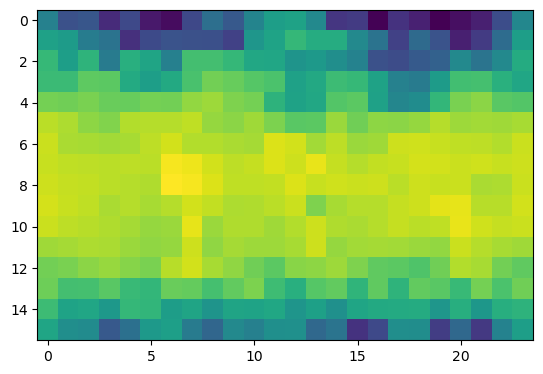

In [69]:
plt.imshow(t.numpy().reshape(-1, 16, 24)[59])

In [189]:
class NaiveDataset(torch.utils.data.Dataset):
    def __init__(self, dsi, dso, params, normalize=False, log=True):
        self.Xmean, self.Xstd, self.Ymean, self.Ystd = diff.mydatasets.get_norm_info(dsi.mli, dso.mlo)
        self.height, self.width = (16, 24)
        self.normalize = normalize
        self.log = log
        if(normalize):
            print("Normalizing")
            self.data = (dso - self.Ymean) / self.Ystd
        else:
            self.data = dso

    def __len__(self):
        return(len(self.data))

    def __getitem__(self, idx):
        if(self.log):
            t0 = log_event("get-batch start", idx)    
        data = self.data[idx].compute()
        if(not self.normalize):
            # wasn't normalized from beginning, must do now
            data = (data - self.Ymean) / self.Ystd
        item = torch.tensor(data.values.reshape(-1, self.height, self.width), dtype=torch.float32)
        if(self.log):
            t1 = log_event("get-batch end", idx, duration=time.time() - t0)
    
        return(item)
        #item = torch.permute(item, (1,2,0)) # Channels Height Width
        

In [89]:
%%time
item = ds_naive[100]

CPU times: user 2.33 s, sys: 887 ms, total: 3.22 s
Wall time: 3.73 s


In [90]:
item.shape

torch.Size([128, 16, 24])

In [154]:
gen = iter(bgen)

In [156]:
%%time
next(gen)

CPU times: user 2.25 s, sys: 926 ms, total: 3.17 s
Wall time: 3.58 s


<xarray.DataArray 'state_t' (time: 32, mlo: 128, ncol: 384)> Size: 13MB
array([[[2.13358017e+02, 2.16159260e+02, 2.14878703e+02, ...,
         2.26919593e+02, 2.22486374e+02, 2.16795982e+02],
        [2.28299843e+02, 2.30452463e+02, 2.27211595e+02, ...,
         2.34395187e+02, 2.32937237e+02, 2.29043129e+02],
        [2.28870474e+02, 2.32700994e+02, 2.30920314e+02, ...,
         2.49616342e+02, 2.46552202e+02, 2.40749574e+02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.94087193e+01, 3.09713231e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.24161710e+01, 7.35890766e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.20048287e+01, 5.14871071e+00, 0.00000000e+00]],

       [[2.13352326e+02, 2.16257061e+02, 2.14902807e+02, ...,
         2.26933566e+02, 2.22528290e+02, 2.16832421e+02],
        [2.28241501e+02, 2.30851448e+02, 2.27201995e+02, ...,
         2.34423187e+02, 2.32927461e+02, 2.29376584e+02],
        [2.28901669e+02, 2.33122067e+02, 2.30960114e+02, ...,
         2.49563087e+02, 2.46470810e+02, 2.40901875e+02],
...
        [8.92988242e+00, 0.00000000e+00, 1.77546523e+00, ...,
         1.34298925e+02, 3.43739190e+01, 1.40215309e+02],
        [3.43834370e+01, 0.00000000e+00, 2.91553543e+01, ...,
         6.33136116e+01, 1.71329396e+02, 9.94583980e+01],
        [2.56405091e+01, 0.00000000e+00, 2.68050382e+01, ...,
         2.91164569e+01, 1.17093345e+02, 5.02856583e+01]],

       [[2.13955147e+02, 2.17850241e+02, 2.16185575e+02, ...,
         2.27870122e+02, 2.25399131e+02, 2.18949327e+02],
        [2.29238853e+02, 2.30100938e+02, 2.26841684e+02, ...,
         2.34878552e+02, 2.36722848e+02, 2.35193468e+02],
        [2.30738138e+02, 2.32813631e+02, 2.30409996e+02, ...,
         2.49881299e+02, 2.47862155e+02, 2.43304639e+02],
        ...,
        [6.65283131e+00, 0.00000000e+00, 1.38579912e+00, ...,
         1.39658265e+02, 7.01308114e+01, 1.03572192e+02],
        [4.17497606e+01, 0.00000000e+00, 2.82196909e+01, ...,
         6.49688294e+01, 1.92147041e+02, 9.17364304e+01],
        [3.19414617e+01, 0.00000000e+00, 2.61210727e+01, ...,
         3.07464093e+01, 1.01188003e+02, 7.89450639e+01]]])
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
Dimensions without coordinates: time

In [161]:
%%time
bgen[1203]

CPU times: user 2.04 s, sys: 797 ms, total: 2.84 s
Wall time: 6.33 s


<xarray.DataArray 'state_t' (time: 32, mlo: 128, ncol: 384)> Size: 13MB
array([[[2.21015673e+02, 2.25063147e+02, 2.21696762e+02, ...,
         2.07656287e+02, 1.99732869e+02, 2.03839198e+02],
        [2.24299614e+02, 2.28782740e+02, 2.27738689e+02, ...,
         2.31945492e+02, 2.26578261e+02, 2.32008976e+02],
        [2.40988850e+02, 2.46974190e+02, 2.44589167e+02, ...,
         2.49895487e+02, 2.55984685e+02, 2.61156799e+02],
        ...,
        [6.09454522e-01, 1.64264531e-06, 9.16103978e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.97267056e+01, 2.79797647e+01, 5.93366416e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.79788825e+01, 1.81637200e+01, 4.32625231e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[2.21022798e+02, 2.25073556e+02, 2.21705957e+02, ...,
         2.07674174e+02, 1.99720844e+02, 2.04001639e+02],
        [2.24250972e+02, 2.28985092e+02, 2.27953226e+02, ...,
         2.31735012e+02, 2.26054463e+02, 2.31817036e+02],
        [2.40957554e+02, 2.47076423e+02, 2.44716859e+02, ...,
         2.49754194e+02, 2.55662528e+02, 2.60693310e+02],
...
        [5.15944464e+00, 2.30310850e-02, 8.61759047e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.46878198e-02],
        [1.16894806e+02, 7.35028450e+01, 3.71881158e+01, ...,
         0.00000000e+00, 0.00000000e+00, 8.96471811e+00],
        [8.71969878e+01, 4.21874638e+01, 2.16175581e+01, ...,
         0.00000000e+00, 0.00000000e+00, 7.96002571e+00]],

       [[2.19761668e+02, 2.24450366e+02, 2.22286235e+02, ...,
         2.09165722e+02, 2.05891522e+02, 2.07899616e+02],
        [2.25452708e+02, 2.29789754e+02, 2.29213349e+02, ...,
         2.33445762e+02, 2.33766267e+02, 2.39435940e+02],
        [2.41479031e+02, 2.46815576e+02, 2.44632680e+02, ...,
         2.49031604e+02, 2.55263428e+02, 2.57198107e+02],
        ...,
        [8.27137069e+00, 2.13299443e-03, 1.08006476e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.68237418e+00],
        [1.09966227e+02, 6.56851097e+01, 2.21262094e+01, ...,
         0.00000000e+00, 0.00000000e+00, 5.79496233e+00],
        [7.21730410e+01, 3.96121220e+01, 2.15539224e+01, ...,
         0.00000000e+00, 0.00000000e+00, 6.24263953e+00]]])
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
Dimensions without coordinates: time

In [163]:
batch = bgen[100]

In [168]:
torch.tensor(batch.values.reshape(-1, 128, 16, 24)).shape

torch.Size([32, 128, 16, 24])

In [179]:
210240 / 32

6570.0

In [178]:
len(bgen)

6570

In [183]:
class XBatchDataset(torch.utils.data.Dataset):
    def __init__(self, dsi, dso, params, normalize=False, log=True):
        self.Xmean, self.Xstd, self.Ymean, self.Ystd = diff.mydatasets.get_norm_info(dsi.mli, dso.mlo)
        self.height, self.width = (16, 24)
        self.normalize = normalize
        self.log = log
        if(normalize):
            print("Normalizing")
            self.data = (dso - self.Ymean) / self.Ystd
        else:
            self.data = dso

        self.bgen = xbatcher.BatchGenerator(dso, 
                input_dims=dict(time=params.batch_size, mlo=128, ncol=384)
                                      )

    def __getitem__(self, idx):
        if(self.log):
            t0 = log_event("get-batch start", idx)
        data = self.bgen[idx].load()
        if(not self.normalize):
            # wasn't normalized from beginning, must do now
            data = (data - self.Ymean) / self.Ystd
        item = torch.tensor(data.values.reshape(-1, 128, self.height, self.width), dtype=torch.float32)
        if(self.log):
            t1 = log_event("get-batch end", idx, duration=time.time() - t0)
        
        return item

    def __len__(self):
        return(len(self.bgen))

In [186]:
dataset = XBatchDataset(dsi, dso, params, normalize=False, log=True)

In [187]:
%%time
dataset[10].shape

{"event": "get-batch start", "time": 1724096170.8688278, "idx": 10, "pid": 1160}
{"event": "get-batch end", "time": 1724096174.178573, "idx": 10, "pid": 1160, "duration": 3.3097405433654785}
CPU times: user 2.13 s, sys: 809 ms, total: 2.94 s
Wall time: 3.31 s


torch.Size([32, 128, 16, 24])

### Trying to optimize

From [earthmover](https://earthmover.io/blog/cloud-native-dataloader/) should see how long a batch takes to process

In [3]:
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn

seaborn.set_context("talk")

In [4]:
def parse_log(fname):
    with open(fname) as f:
        lines = f.readlines()

    messages = []
    for line in lines:
        try:
            messages.append(json.loads(line.strip()))
        except json.JSONDecodeError:
            pass
    return messages


def plot_wait_time(messages, ax, title="Time waiting"):
    if title:
        ax.set_title(title)

    wait_times = []
    end = None
    for m in messages:
        if m["event"] == "training end":
            end = m["time"]
        if m["event"] == "training start" and end is not None:
            wait_times.append(m["time"] - end)

    wait_times = np.array(wait_times)
    max_show = wait_times.mean() + 3 * wait_times.std()

    print("average wait time", wait_times.mean())

    ax.hist(wait_times, bins=np.linspace(0, max_show, 100), color="#6D0EDB")[-1]
    ax.set_xlabel("time (sec)")

In [5]:

def plot_log(messages, ax, title=""):
    origin = messages[0]["time"]
    assert messages[0]["event"] == "run start"

    rows = {"setup": 3, "get-batch": 2, "train": 1, "epoch": 0}

    ax.set_yticks(list(rows.values()), labels=list(rows))

    if title:
        ax.set_title(title)

    data = {"batches": []}

    for m in messages:
        t = m["time"] - origin

        if m["event"] == "setup end":
            ax.barh(
                rows["setup"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#6D0EDB",
                zorder=1,
            )

        if m["event"] == "get-batch end":
            ax.barh(
                rows["get-batch"],
                m["duration"],
                left=t - m["duration"],
                # alpha=0.5,
                color="#C396F9",
                zorder=1,
            )
            data["batches"].append(m["duration"])

        if m["event"] == "training end":
            ax.barh(
                rows["train"],
                m["duration"],
                left=t - m["duration"],
                color="#FF6554",
                zorder=1,  # edgecolor="k", linewidth=0.1,
            )

        if m["event"] == "epoch end":
            ax.barh(
                rows["epoch"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#FF9E0D",
                zorder=1,
            )

    ax.grid(axis="x", zorder=0, alpha=0.5)
    ax.set_xlabel("time (sec)")

    print("average batch duration", np.mean(data["batches"]))


def plot(fname):
    messages = parse_log(fname)
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6), width_ratios=[3, 1], dpi=400)

    plot_log(messages, axes[0], title="")
    plot_wait_time(messages, axes[1], title="")

    for m in messages:
        if m["event"] == "run start":
            text_str = "\n".join([f"{k}: {v}" for k, v in m["locals"].items() if v is not None])
            props = dict(boxstyle="round", facecolor="#F5F5F5", alpha=0.5)
            fig.text(
                0.5,
                -0.03,
                text_str,
                fontsize=14,
                horizontalalignment="center",
                verticalalignment="top",
                bbox=props,
            )
            break

In [6]:
base_dir = "experiments/data_tests/"

path = lambda fname : os.path.join(base_dir, fname)

average batch duration 3.0209433032620336
average wait time 3.0182402627221467


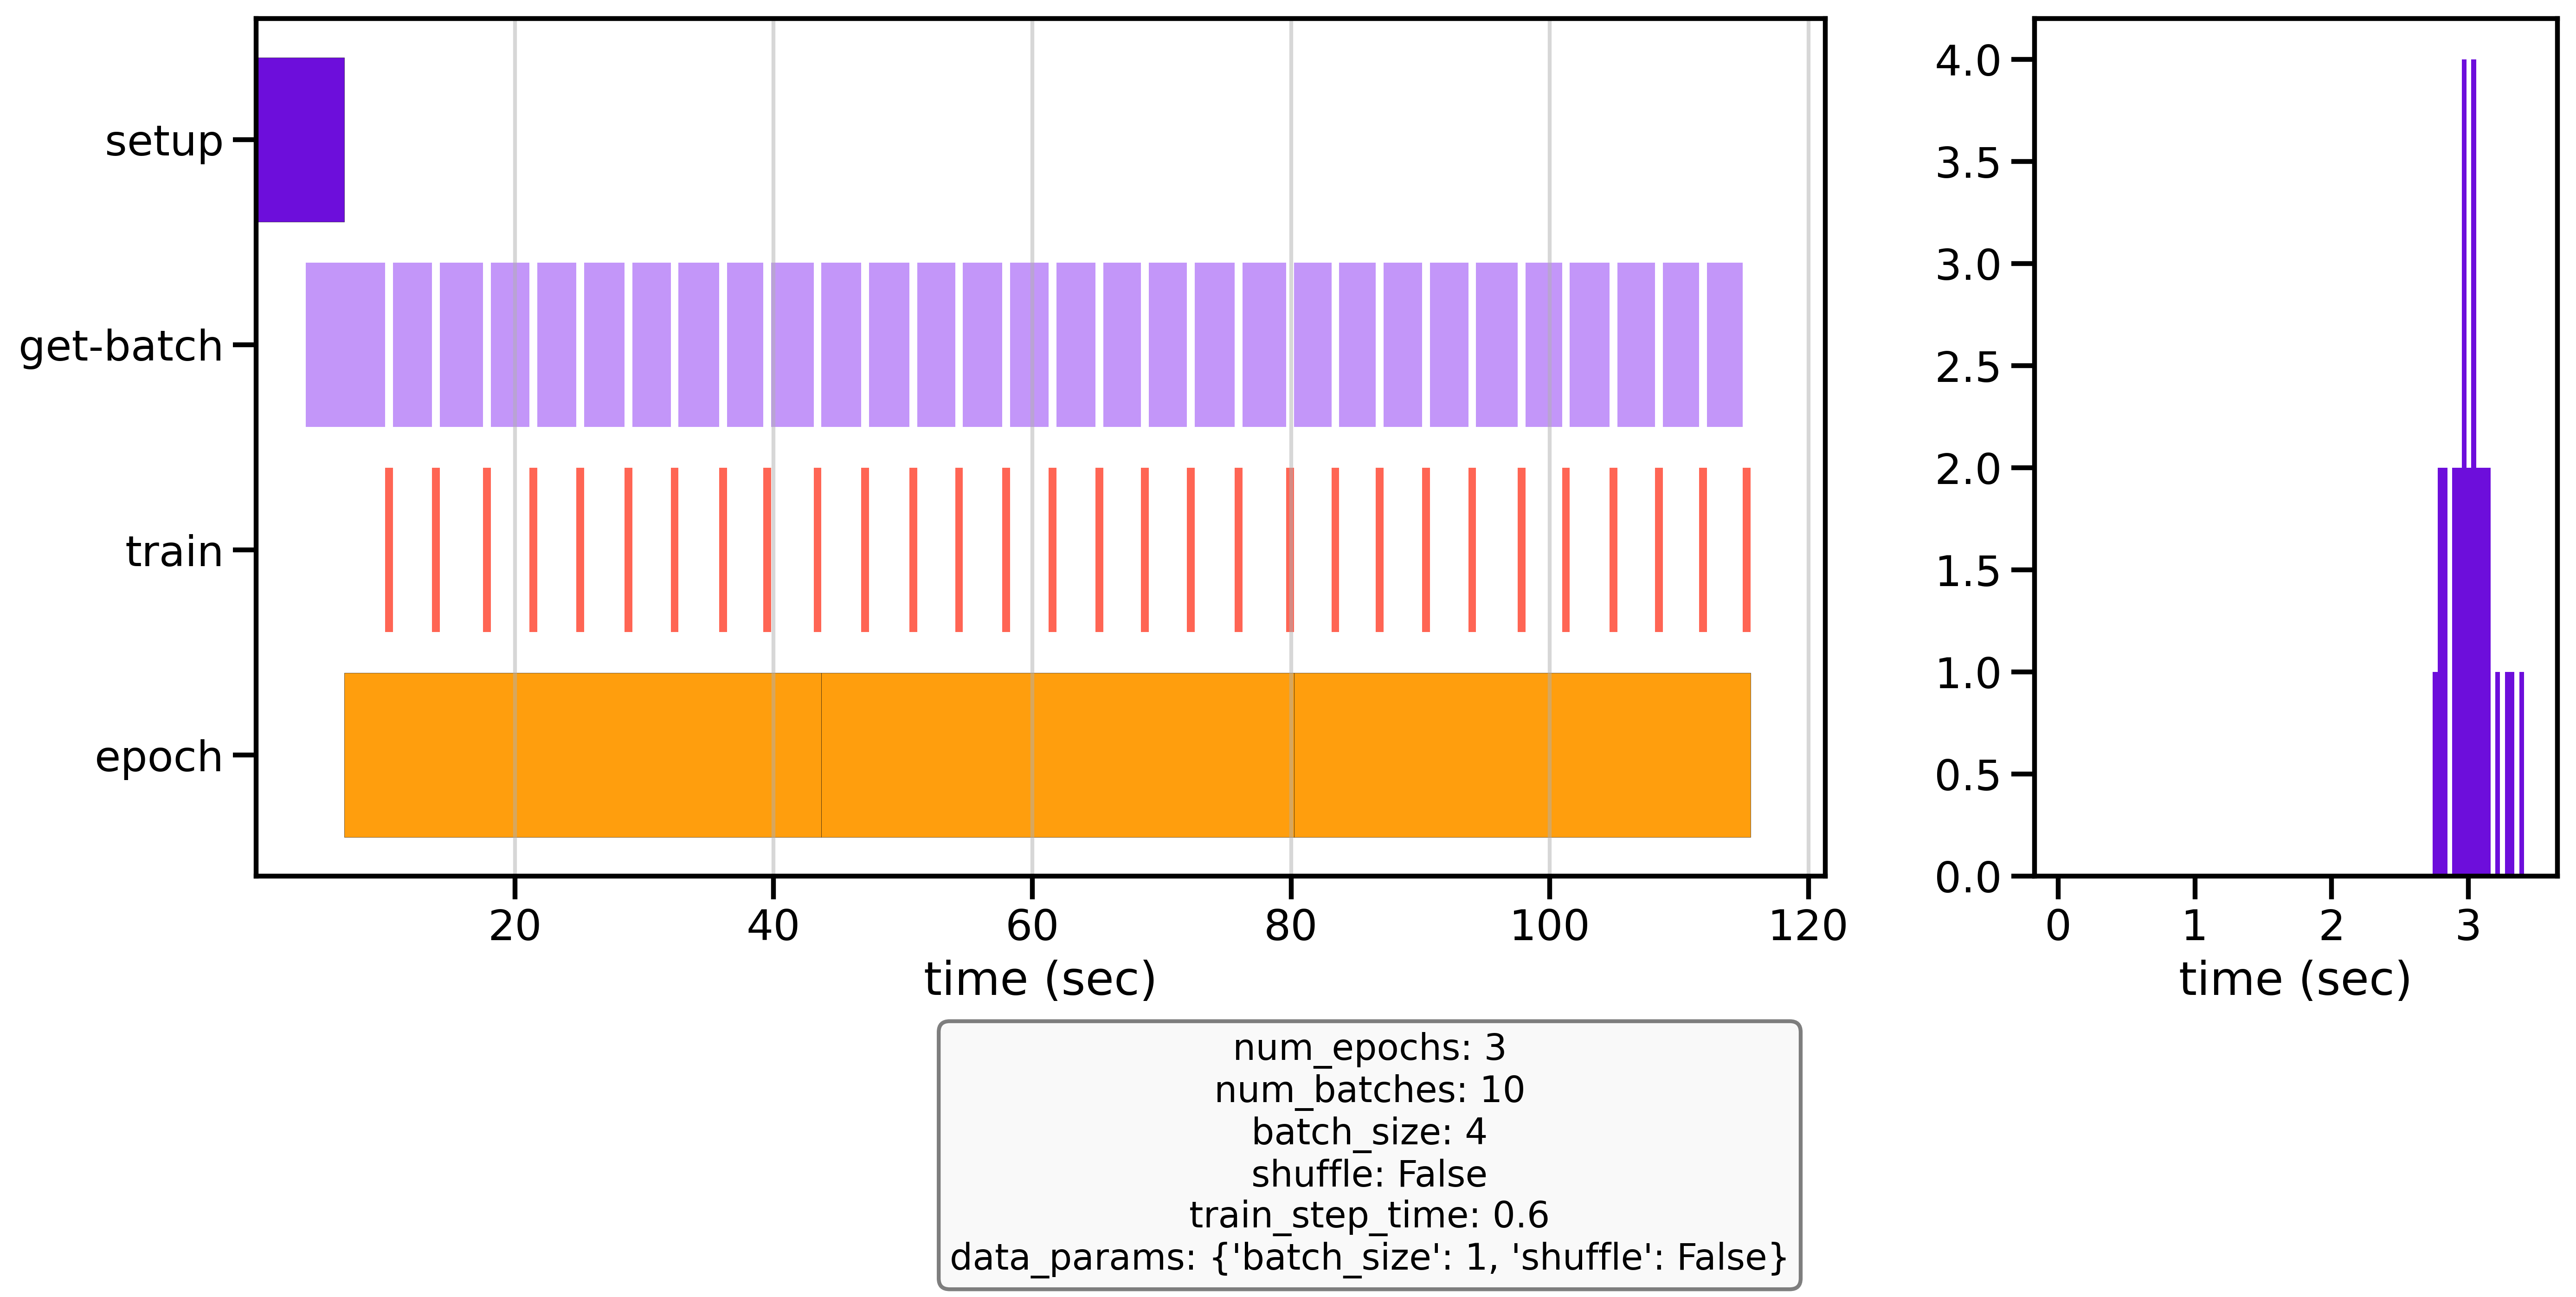

In [9]:
plot(path("trial-1.txt"))

average batch duration 3.5854305822022106
average wait time 0.0902443187292603


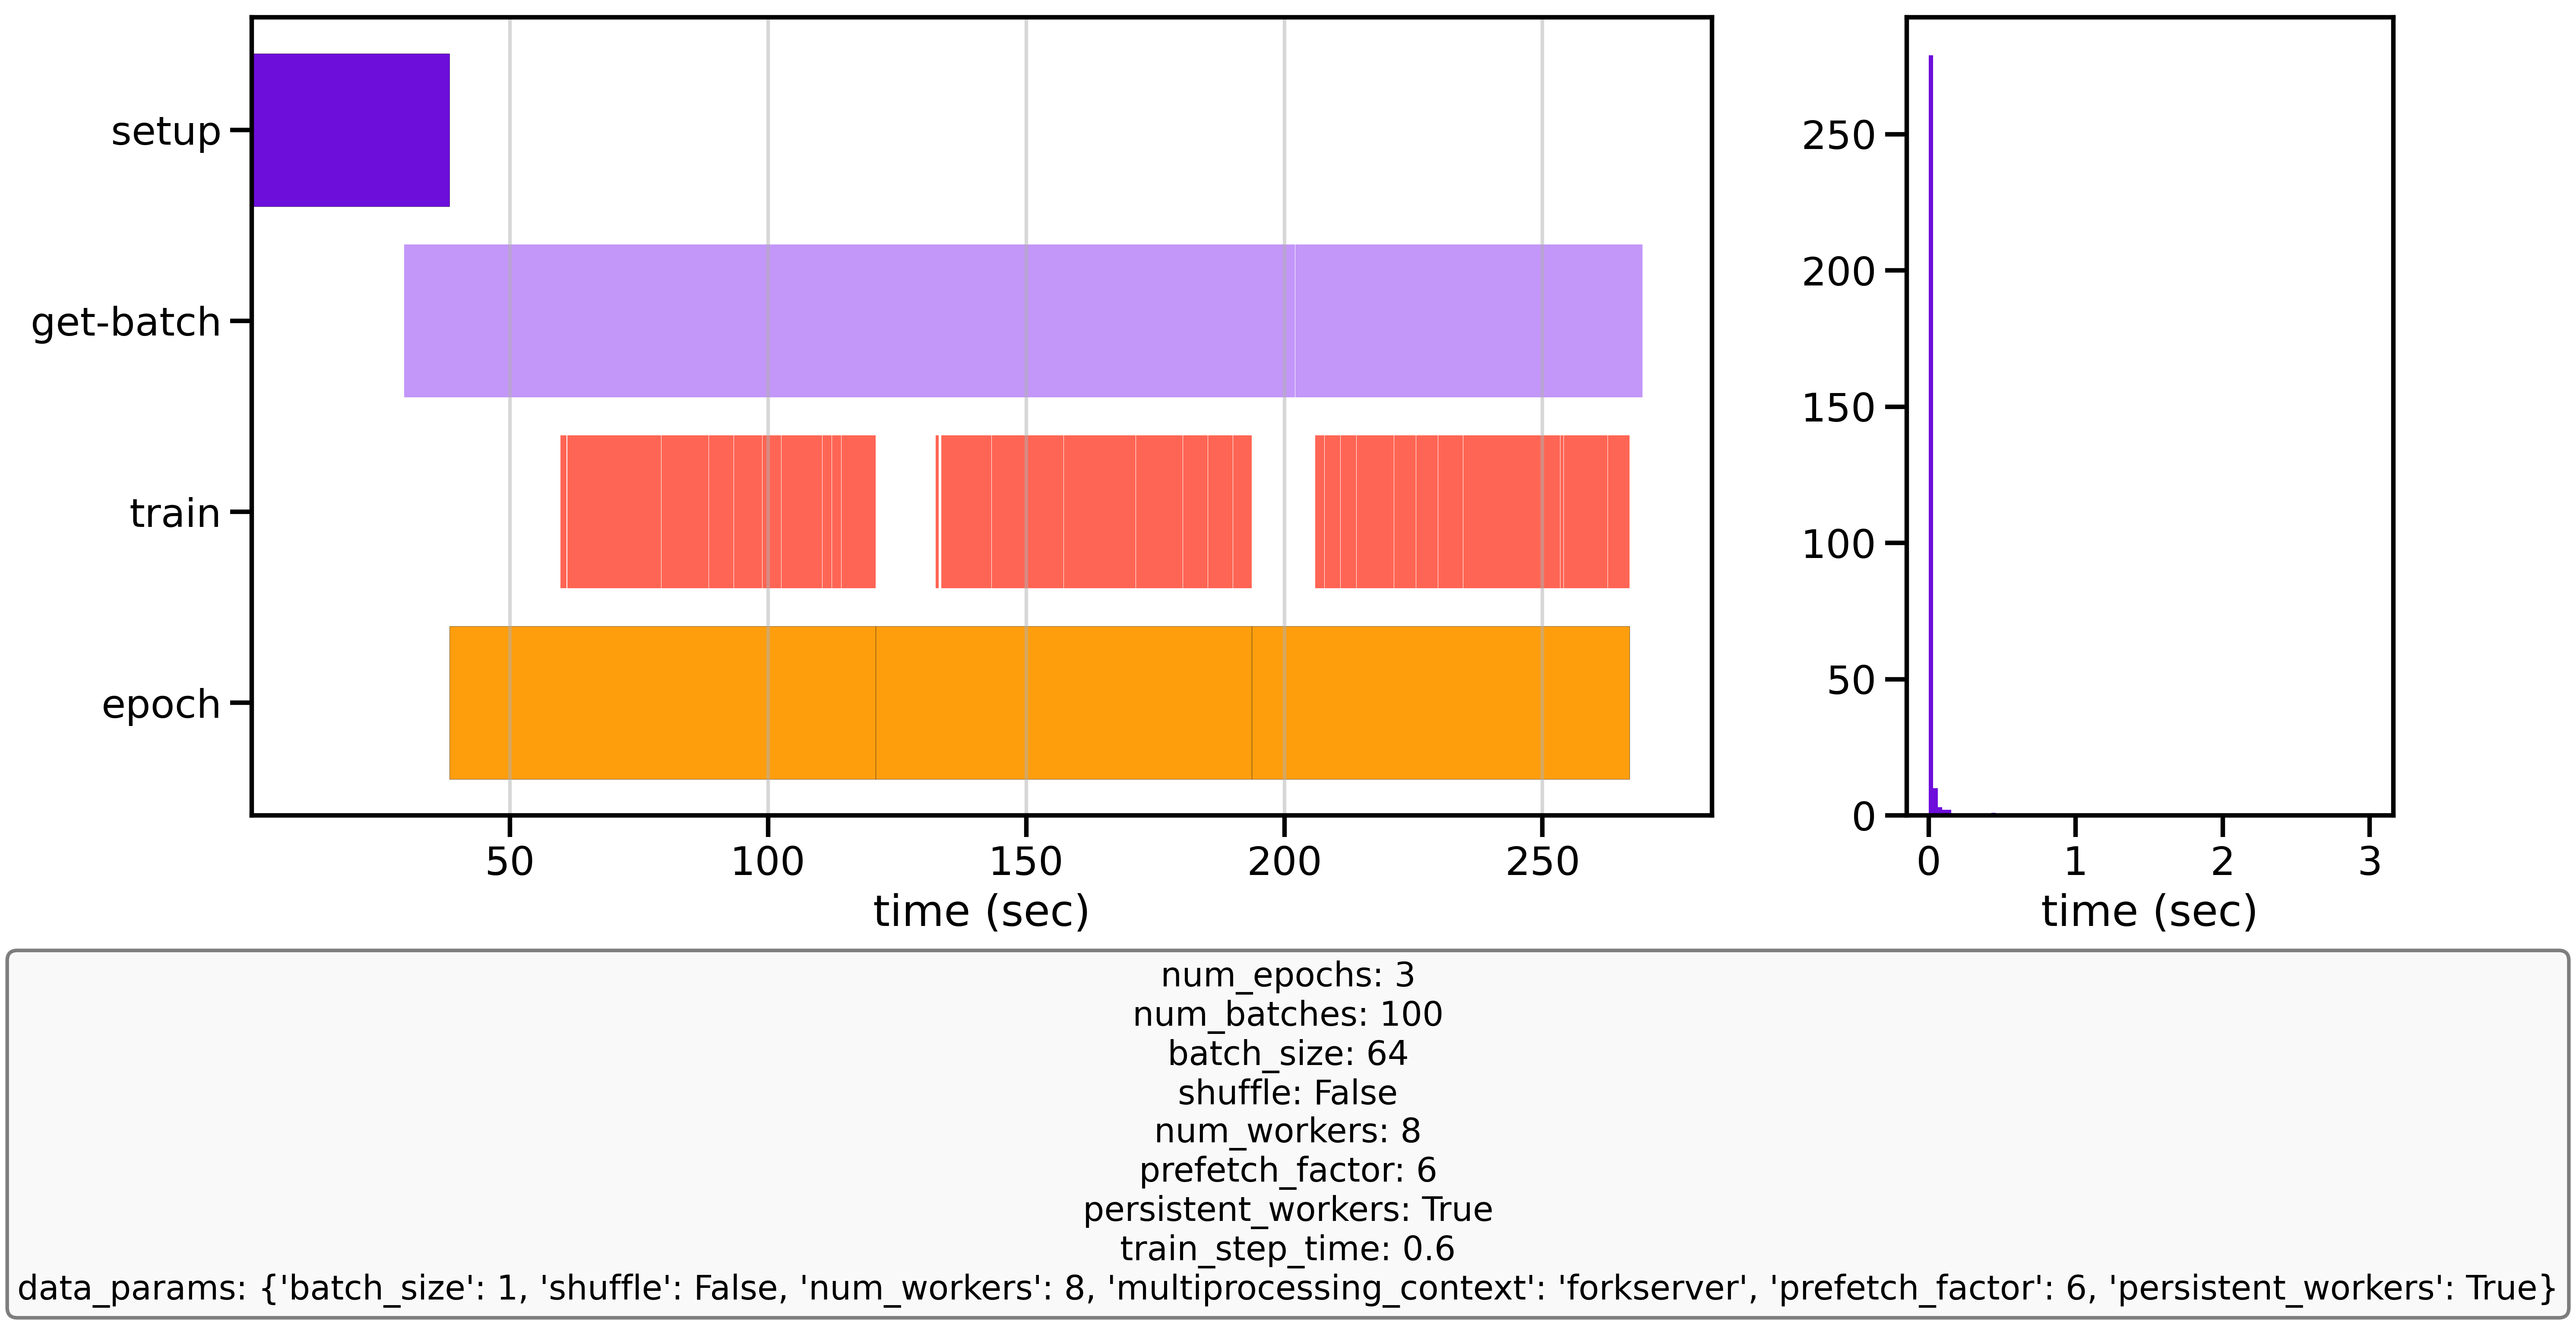

In [10]:
plot(path("trial-2.txt"))

In [96]:
params.batch_size = 32
params

DataConfig(chunksize={}, shuffle=False, batch_size=32, num_workers=0, prefetch_factor=None, persistent_workers=False, pin_memory=False, train_step_time=0.1, dask_threads=None, dask_scheduler='single-threaded', bg_input_dims={'time': 32, 'ncol': 384}, multiprocessing_context=None)

In [97]:
dataloader = DataLoader(
    ds_naive, shuffle=params.shuffle, batch_size = params.batch_size,
    num_workers=params.num_workers, multiprocessing_context= params.multiprocessing_context, prefetch_factor=params.prefetch_factor,
    persistent_workers=params.persistent_workers, pin_memory=params.pin_memory
)

In [99]:
%%time
batch = next(iter(dataloader))

CPU times: user 1min 29s, sys: 28.4 s, total: 1min 58s
Wall time: 1min 53s


Timing how long running a batch takes

In [107]:
tconfig, mconfig = diff.load_config("trial_log", "test_ddpm_1")
mconfig.scheduler_type = 'ddim'

In [134]:
ddpm = diff.fetch_model_from_ckpt("best-ckpt.pt", "trial_log", "test_ddpm_1").to(device=device)

In [135]:
trainer = diff.DiffusionTrainer(ddpm, dict(train=ds_naive), torch.nn.MSELoss(), tconfig, mconfig, 'dataloader_tests') 
trainer                              

In [136]:
scheduler = diff.mydatasets.load_scheduler(mconfig)
scheduler

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.30.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 100,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [138]:
def noise_batch(clean_images, scheduler):
    """
    Given a batch from a dataloader on the dataset, return a noised sample
    """
    # TODO : do performance comparison between this and collate_fn __getitem__
    noise = torch.randn(clean_images.shape, device=device)
    timesteps = torch.randint(0, scheduler.config.num_train_timesteps, 
                    size=(clean_images.shape[0],), device=device, dtype=torch.int64)
    noisy_images = scheduler.add_noise(clean_images, noise, timesteps)
    return(noisy_images, timesteps, noise)

In [127]:
batch = noise_batch(batch.to(device=device), scheduler)

In [139]:
%%time
trainer._run_batch(batch, "train")

CPU times: user 397 ms, sys: 146 ms, total: 543 ms
Wall time: 543 ms


tensor(0.4997, device='cuda:0', grad_fn=<MseLossBackward0>)

Trying to implement the optimizations and strategies from [this Earthmover blog](https://earthmover.io/blog/cloud-native-dataloader/)

In [230]:
%%time
batch = next(iter(dataloader))
batch.shape

CPU times: user 2.57 s, sys: 1.08 s, total: 3.64 s
Wall time: 5.13 s


torch.Size([1, 32, 128, 16, 24])

In [225]:
def main():
    for epoch in range(num_epochs):
        e0 = time.time()
        print_json({"event": "epoch start", "epoch": epoch, "time": e0})

        for i, sample in enumerate(training_generator):
            tt0 = time.time()
            print_json({"event": "training start", "batch": i, "time": tt0})
            time.sleep(train_step_time)  # simulate model training
            tt1 = time.time()
            print_json({"event": "training end", "batch": i, "time": tt1, "duration": tt1 - tt0})
            if i == num_batches - 1:
                break

        e1 = time.time()
        print_json({"event": "epoch end", "epoch": epoch, "time": e1, "duration": e1 - e0})